In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

(-0.20712212955239995,
 4.202739116707028,
 0.007282808674363386,
 1.012375036164011)

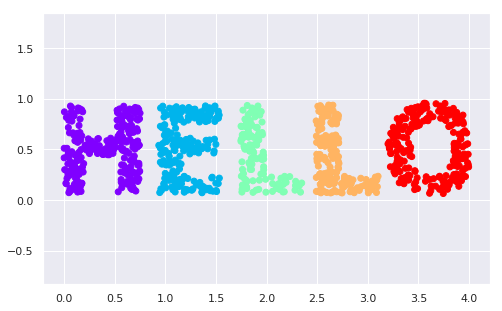

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:,1], **colorize)
plt.axis('equal')

## 多次元尺度構成法

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
            [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

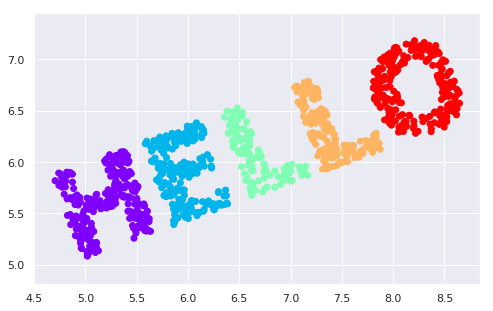

In [5]:
X2 = rotate(X, 20) + 5
plt.figure(figsize=(8, 5))
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

In [6]:
from sklearn.metrics import pairwise_distances

In [7]:
D = pairwise_distances(X)
D.shape

(1000, 1000)

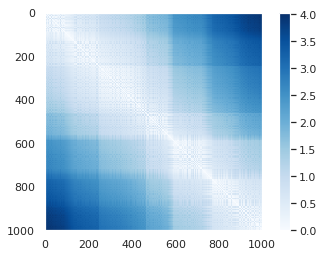

In [8]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

In [9]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

In [10]:
from sklearn.manifold import MDS

(-2.0677590819075964,
 2.1283350124574927,
 -1.374706994590171,
 1.3745656559020414)

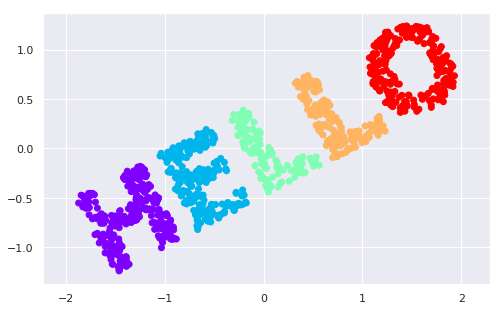

In [11]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.figure(figsize=(8, 5))
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

## 多様体学習としてのMDS

In [12]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

In [13]:
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

In [14]:
from mpl_toolkits import mplot3d

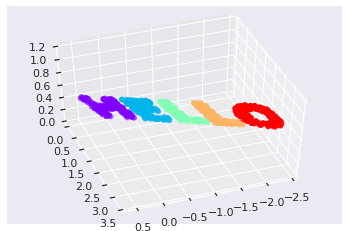

In [15]:
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize)
ax.view_init(azim=70, elev=50)

(-2.067759081907622,
 2.128335012458156,
 -1.3747069945903772,
 1.3745656559066646)

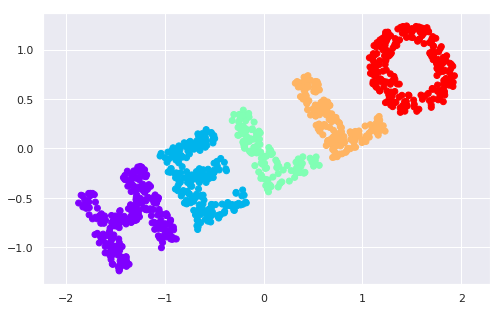

In [16]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.figure(figsize=(8, 5))
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal')

## 非線形埋め込み：MDSがうまくいかない場合

In [17]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

In [18]:
XS = make_hello_s_curve(X)

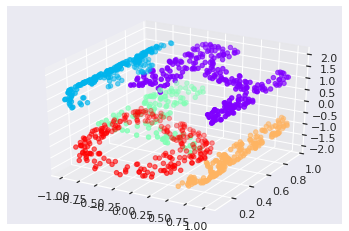

In [19]:
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize)

In [20]:
from sklearn.manifold import MDS

(-2.137743958785896,
 1.9525966315357768,
 -1.9667872566209792,
 1.7978925909661077)

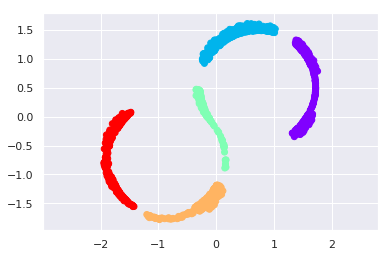

In [21]:
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal')

## 非線形多様体：局所線形埋め込み

In [22]:
from sklearn.manifold import LocallyLinearEmbedding

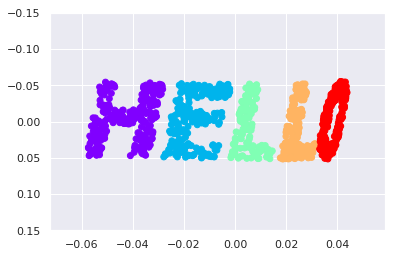

In [23]:
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

## 事例：顔画像へのlsomap適用

In [24]:
from sklearn.datasets import fetch_lfw_people

In [27]:
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

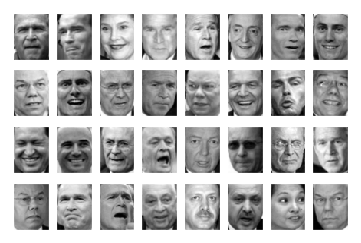

In [28]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

In [29]:
from sklearn.decomposition import PCA

In [30]:
model = PCA(100, svd_solver='randomized').fit(faces.data)

Text(0, 0.5, 'cumulative variance')

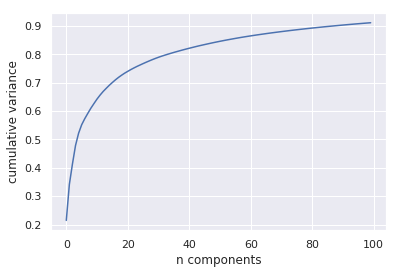

In [31]:
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')

In [32]:
from sklearn.manifold import Isomap

In [33]:
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [35]:
from matplotlib import offsetbox

In [36]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

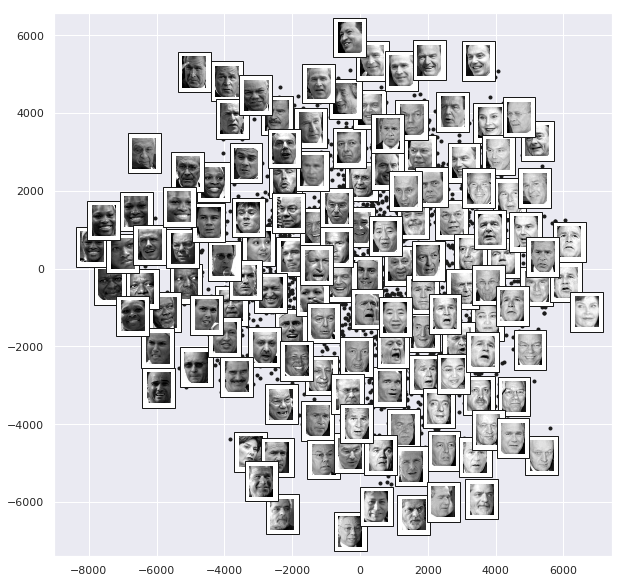

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

In [53]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

/Users/shimizukousuke/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/shimizukousuke/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


(70000, 784)

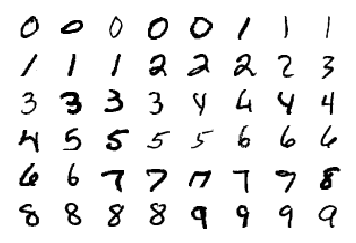

In [54]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

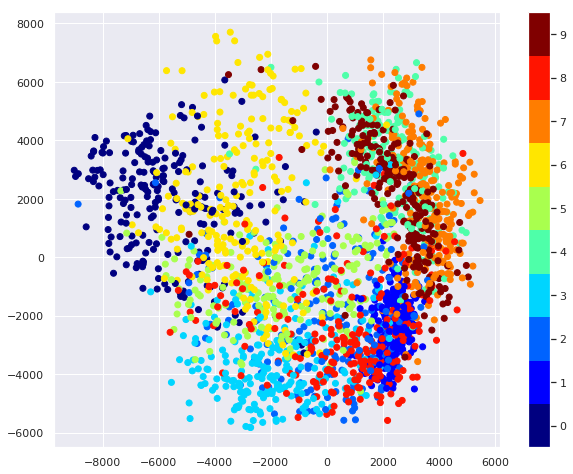

In [57]:
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.figure(figsize=(10, 8))
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

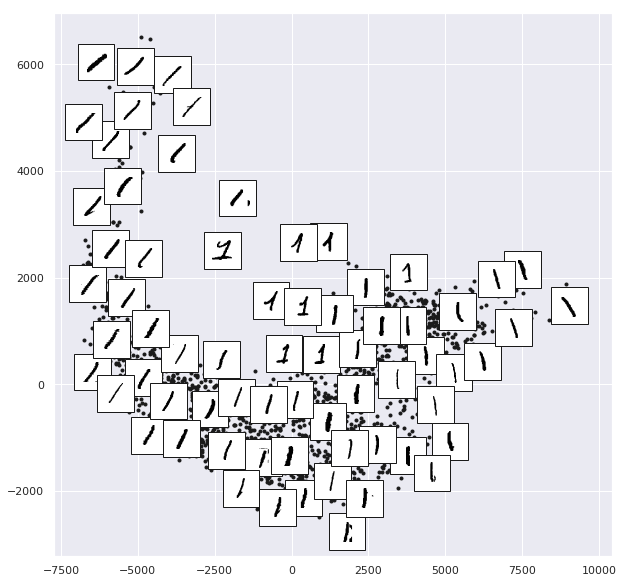

In [58]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')